# Introduction

## Overview

This is a variation of [the original Analysis notebook](https://github.com/kamfonas/squadBERT/blob/main/notebooks/Analysis_v1.ipynb) with added functionality to exploit json files produced after validation or testing. 

Our premise, as described in more detail in the Analysis notebook, is that in addition to using exact match or F1 scores, measuring the proximity to the top prediction of the correct answer, provides useful insight into the progress of learning, hyperparameter tuning, or the comparison of models and architectures. 

We initially adopt the formatting proposed by Huggingface since their hub includes a large collection of architectures and models for the QA task. At the end of validation or test runs, a post-processing function yields a json file with the N-best answers for each example. Using N=20, for example, we can  extract the top 20 predictions for each example tested. Since we know the top 4 answers for every example from the golden dataset, we can try to match them in the top 20-list, and rank or score the proximity of the correct answers to highest confidence predictdion. 

This notebook demonstrates how we can pair the golden answers to our top-N predictions and calculates various metrics that measure proximity or rank of the correct answer.

In [113]:
%%capture
!pip install datasets

In [2]:
#https://stackoverflow.com/questions/63329657/python-3-7-error-unsupported-pickle-protocol-5
#import pickle5 as pickle
import pandas
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.patches import Rectangle
import seaborn as sns
import urllib
#import wget
from utils_anal import *
#rename things that arent logs later
import os
from pathlib import Path
import json
from collections import Counter
import datetime
import datasets
from datasets import ClassLabel, Sequence, load_dataset, load_metric
import random
import pandas as pd
from IPython.display import display, HTML
import datetime
import string
import re
from statistics import  median_grouped
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [3]:
def download_url(url, output_path, show_progress=True):
    class DownloadProgressBar(tqdm):
        def update_to(self, b=1, bsize=1, tsize=None):
            if tsize is not None:
                self.total = tsize
            self.update(b * bsize - self.n)

    if show_progress:
        # Download with a progress bar
        with DownloadProgressBar(unit='B', unit_scale=True,
                                 miniters=1, desc=url.split('/')[-1]) as t:
            urllib.request.urlretrieve(url,
                                       filename=output_path,
                                       reporthook=t.update_to)
    else:
        # Simple download with no progress bar
        urllib.request.urlretrieve(url, output_path)

stanford_squad2_dev_url = "https://rajpurkar.github.io/SQuAD-explorer/dataset/dev-v2.0.json"
save_stanford_squad2 = "stanford_squad2_dev.json"
download_url(stanford_squad2_dev_url,save_stanford_squad2)

dev-v2.0.json: 4.37MB [00:01, 3.17MB/s]                                         



## Load the SQuAD Dataset

We now download the squad_v2 dataset from the hub. We will use it to get the golden answers so that we can calculate performance metrics. The dataset class has a method for loading the dataset from the huggingface hub or from a disk location. The loaded object belongs to that class



In [138]:
dataset_name = "squad_v2"
#dataset_name = "squad"

raw_datasets = load_dataset(dataset_name)
#print('The raw dataset dictionary contains two datasets of type %s:' % (type(raw_datasets["validation"])))
raw_datasets

#['num_rows']


Found cached dataset squad_v2 (/Users/gabrielalon/.cache/huggingface/datasets/squad_v2/squad_v2/2.0.0/09187c73c1b837c95d9a249cd97c2c3f1cebada06efe667b4427714b27639b1d)


  0%|          | 0/2 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 130319
    })
    validation: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 11873
    })
})

The following function allows us to inspect the contents of the downloaded data. Every time the function is invoked it prduces a new set of random selections.

Every time you execute this function it will generate new samples. Use it to find IDs you want to use for testing.

In [129]:
#show_random_elements(raw_datasets["validation"])

We are interested in the validation dataset. Here is its type:

In [130]:
type(raw_datasets["validation"])

datasets.arrow_dataset.Dataset

## Index by ID


In order to be able to match the entries of the original dataset with those of our prediction, we need to map each ID to the respective row number of the validation raw dataset. We construct an index, as a dictionary, keyed on the ID from the validataion raw dataset and pointing to the corresponding row-number of the validation dataset.

In [131]:
ix_id = dict([(x['id'],i) for i,x in enumerate(raw_datasets['validation'])])

Now, we can use this index to get to the golden answer for a given id. This mapping is repeated inside the class defined in the next section below. 



# The ResultSet Class

## Class Overview


To facilitate management and data collection we build a dictionary of available data sources derived from runs logged under a user-provided root directory (saveRoot.)

The SaveRoot descendent directories are searched for all instances of a fiile named *eval_nbest_predictions.json*. Every directory containing this file is a potential source for N-best predictions. We load the ones that satisfy these additional conditions:

1.  if a *config.json* file exists in the same directory
2.  If a file named *all_results.json* exists in the same directory

These files are written by the training/evaluation process after successful completion of a run. 

The function **get_resultsets_from_root(saveRoot)** performs the above steps and returns a directory with the following information:

<dl>
<dt><b>mtime</b></dt>
    <dd>The last modification time of the eval_nbest_predictions.json file</dd>
<dt><b>config</b></dt>
    <dd>Model configuration of used to produce the top-N results</dd>
<dt><b>all_results</b></dt>
    <dd>The results of the last run that produced the top-N results</dd>
<dt><b>topN</b></dt>
    <dd>A dictionary keyed on the ID of each question pointing to an ordered N-long list in descending order of probability with the predicted details. These details are organized as dictionaries containing:
    </ul>
    <li><b>start logit</b></li>
    <li><b>end logit</b></li>
    <li><b>answer text</b></li>
    <li><b>probability</b></li>
    </ul>
    </dd>
<dt><b>null odds</b></dt>
    <dd>The odds determining the likelihood that this is a no-answer question for each example</dd>
</dl>

We augment our **prediction** dictionary to include the **id** as a field, the **rank** of each predicted answer (with values from 0 to N), and the gold answers (**goldenAnswers**), which is a list containing the distinct text of the answers found in the SQuAD_V2 dataset. Finally, we also include an indicator showing whether the prediction is the **correct** answer.

The **contextLen** field denotes the original number of characters in the context field. This can be used for normalization when comparing probabilities of different size contexts. A more appropriate length would be the number of tokens or number of words in the context.  

Notice that to indicate no answer, the prediction text is an empty string while the goden answer is an empty list. 

The class, when initialized with a root directory, searches all its subdirectories to find top-N prediction output files. It also accepts an original examples dataset which was used as input to our training/evaluation script. From these two pieces of information, the class materializes a number of dictionaries and carries methods for data extraction and generating all necessary values for visualizations. 

Method topNPredsDF takes an optional maxBins parameter that sets a limit to the rank values. The function returns a pandas dataframe that contains the following columns:
    <ul>
    <li><b>start logit</b></li>
    <li><b>end logit</b></li>
    <li><b>answer text</b></li>
    <li><b>probability</b> derived from the combination of start and end probabilities</li>
    <li><b>experiment</b> derived from the output directory path</li>
    <li><b>example id</b></li>
    <li><b>rank</b> in descending order of probability for as many available ranks are available in the logs.
    <li><b>bins</b> this is driven by the topK parameter and is assigned the rank value up to the maxBins parameter. This is a convenient way to throttle very long top-N lists to a desired max size for plotting purposes. All the rows that exceed the rank are still available, but the rank number is the same maximum value (defaults to 20)</li>
    <li><b>correct</b> is True if it matches one of the golden answers using the exact match logic (EM) regardless of rank</li>
    <li><b>contextLen</b> in characters</li>
    </ul>



## Create a Class Instance and List Summary Info 

In [132]:
RS = ResultSet("../save-models/squad_v2",raw_datasets["validation"])


KeyboardInterrupt: 

In [ ]:
RS.summaryDF()


In [11]:

#with open('../assets/experSummary.tex','w') as F:
 #   F.write(RS.summaryDF().to_latex())

In [12]:
# RS.experiments #16 experiment names 5 model architectures

['/bert-base-uncased/001',
 '/bert-base-uncased/007',
 '/bert-base-uncased/009',
 '/bert-base-uncased/010',
 '/bert-large-cased-whole-word-masking/003',
 '/deepset/bert-large-uncased-whole-word-masking-squad2/001',
 '/mrm8488/longformer-base-4096-finetuned-squadv2/009',
 '/mrm8488/longformer-base-4096-finetuned-squadv2/011',
 '/navteca/electra-base-squad2/005',
 '/navteca/electra-base-squad2/006',
 '/navteca/electra-base-squad2/007',
 '/navteca/roberta-base-squad2/001',
 '/navteca/roberta-base-squad2/002',
 '/twmkn9/distilbert-base-uncased-squad2/003',
 '/twmkn9/distilbert-base-uncased-squad2/004',
 '/twmkn9/distilbert-base-uncased-squad2/008']

The summary lists the name (derived from the directory structure) for each experiment captured in the class, followed by the last modification date, , the number of examples in the dataset, and the length of the top-K predictions recorded in the logs.


## Assign Labels to Experiments
We assign abbreviated labels for each experiment to keep legends small

In [133]:
short_labels = []
for exp in RS.experiments:
    nm1 = exp.split('/')
    nm0 = nm1[-2]
    #print(exp,str(namSplit2[0])+'/'+str(namSplit1[-1]))
    nm0 = re.sub('-base','',nm0)
    nm0 = re.sub('large','lg',nm0)
    nm0 = re.sub('uncased','uc',nm0)
    nm0 = re.sub('cased','cas',nm0)
    nm0 = re.sub('whole-word-masking','wwm',nm0)
    nm0 = re.sub('-finetuned','',nm0)
    nm0 = re.sub('-squad.*2','-sq2',nm0)
    nm0 = re.sub('-[0-9]{4}','',nm0)  
    short_labels.append(str(nm0+'/'+str(nm1[-1])))
RS.set_labels(short_labels)
#RS.labels

In [134]:
abbrevLabel = {RS.experiments[i] : RS.labels[i] for i in range(len(RS.labels))}

## Looking-up Information for a Specific Example ID

In [136]:
#RS.dataset[RS.ix_id['571c96095efbb31900334dc0']] 

In [137]:
#ids=['57263c78ec44d21400f3dc7c', '57267d52708984140094c7da', '5728dc2d3acd2414000e0080', '572742bd5951b619008f8787']
#RS.dataset[RS.ix_id[ids[0]]] 

## Explore random example top-K predictions
But first, let's explore the data dictionary we assembled and look at a three random examples. 

1.  We first select **num_examples** (default to 3) numbers in the range of all the keys of the data dictionary
2.  Look up the keys that appear at these three sequencial positions in the sequence of all keys
3.  Get the values pointed to by those keys
4.  Build a data frame by traversing the list of each of the chosen values and extracting the field names and fields.
5.  Finally display the rank, predicted answer text,  golden answer list,  probability used to rank this choice, and whether this is a correct prediction. 

Every time the command is issued new random samples are displayed. 

In [149]:
DF = RS.show_random_qa_predictions(3,num_examples = 500, verbose = False)
DF
#gabrielalon
#DF = DF[DF['rank']==10]
#DF = DF[DF['correct']==True] #this doesnt gaurantee that the sd is 0 there though
#DF

,id,rank,text,goldAns,probability,correct
0,5ad545545b96ef001a10ac07,0,resources (such as time or space) are bounded,[],0.331290,False
1,5ad545545b96ef001a10ac07,1,when resources (such as time or space) are bou...,[],0.330268,False
2,5ad545545b96ef001a10ac07,2,"resources (such as time or space) are bounded,...",[],0.060845,False
3,5ad545545b96ef001a10ac07,3,when resources (such as time or space) are bou...,[],0.060657,False
4,5ad545545b96ef001a10ac07,4,"resources (such as time or space) are bounded,...",[],0.047590,False
...,...,...,...,...,...,...
5133,572826634b864d19001645c0,5,twelfth most populous,"[largest Filipino American community, largest]",0.005696,False
5134,572826634b864d19001645c0,6,largest Filipino American community,"[largest Filipino American community, largest]",0.005314,True
5135,572826634b864d19001645c0,7,twelfth most populous city in the United States,"[largest Filipino American community, largest]",0.005267,False
5136,572826634b864d19001645c0,8,"largest Filipino American community, with 25,0...","[largest Filipino American community, largest]",0.003401,False


We can save a latex version of the output

In [20]:
#with open('../assets/randomtopKpredictions2.tex','w') as F:
 #   F.write(DF.to_latex())

# EM and F1 Evaluation Metircs

These are extracted from the reported validation metrics for each experiment. They include exact match (EM) and F1 scores for the questions with answers and those with no answers separately, as well as all of them in total. Notice that there is no distinction between exact match and F1 for no-answer questions. 

In [115]:
#RS.eval_metrics()

## F1 is highly correlated with Exact Match
The following plot uses the data above to demonstrate the high correlation between EM and F1 scores.

In [ ]:
#gabrielalon deleted

# Golden Prediction Rank

## Definition

The Golden Prediction Rank, or simply Golden Rank (GR)  is defined as the rank of the highest probability prediction that exactly matches one of the answers. Operationally, this is better visualized following these steps:

1.  Assume an ordered list from highest to lowest probability of all valid spans of the context of a given example
2.  Starting from the top, in descending probability order, try each of the spans and identify the first one that contains an exact match to any of the golden answers
3.  The rank of that element is the golden prediction rank (GR) for that example


## Top-10 GRs Fine-Tuned Model Eval Runs

These include all evaluations using models that we did not fine-tune or train, but downloaded them already fine-tuned on SQuAD v2.

We first extract the top-K ranking predictions for each experiment. 

In [163]:
#gabrielalon 
import sys
import numpy
#numpy.set_printoptions(threshold=sys.maxsize)
#this function calculates the golden ranks for each question, the next step is the mean.
#the id of the question is lost here though
grls_np, nas_np, maxBins, medians, grls = RS.calc_golden_ranks(maxBins = 10,experimentIdx=6)
grs = grls_np
print((grs[0][:5]))
print(len(grs[0])) #why 11873 ranks?
#print((grs[0]))

[0 0 1 1 0]
11873


In [ ]:
"""
#before doing this verify that experimentIdx is sufficient to read the original quesiton, passage, answers
Call RS.calc_golden_ranks on a list every experimentIdx string
if any of the output is below 10 then "continue" to next experimentIdx
if didn't skip/continue then save that experimentIdx to my desired list
"""

# Clustering of Examples by Model Performance

Text(0.5, 1.0, 'All Golden Ranks of All Examples, All Experiments')

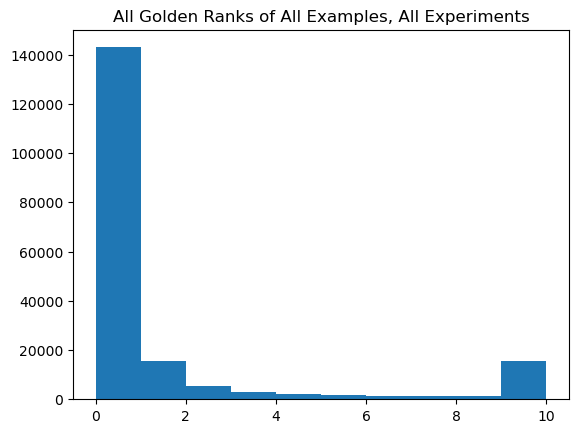

In [62]:
#%matplotlib notebook
#plt.hist(grs.T)
flat_all = [item for sublist in (grs.T) for item in sublist]
plt.hist(flat_all);
plt.title('All Golden Ranks of All Examples, All Experiments')

'\nThis plot proves that there are examples at every rank (what is past rank 10???)\n'

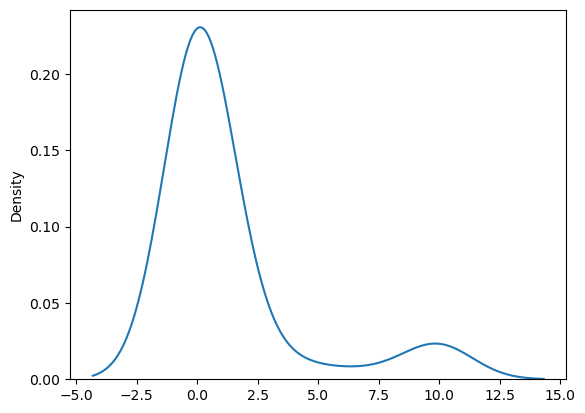

In [67]:

#sns.set_style('whitegrid')
sns.kdeplot(np.array(flat_all), bw=0.5)

"""
This plot proves that there are examples at every rank (what is past rank 10???)
"""

In [68]:
import matplotlib


Text(0.5, 1.0, 'Golden Ranks of Ans Examples, All Experiments')

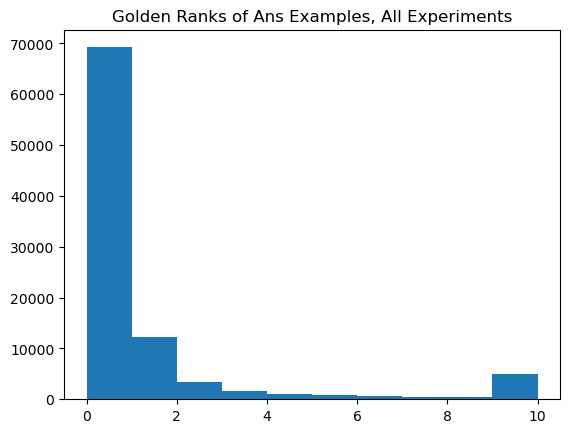

In [69]:
#d.T
#plt.hist(grs.T)
#plt.show()
%matplotlib inline

flat_ans = [item for sublist in (grs_ans.T) for item in sublist]
plt.hist(flat_ans);
plt.title('Golden Ranks of Ans Examples, All Experiments')
#plt.show()

Text(0.5, 1.0, 'Golden Ranks By Type')

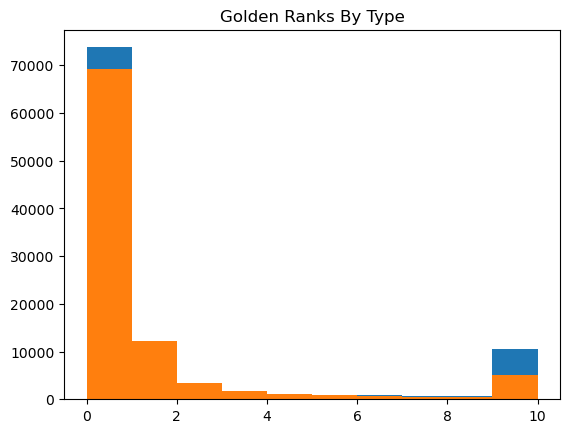

In [70]:
flat_na = [item for sublist in (grs_na.T) for item in sublist]
plt.hist(flat_na);
plt.hist(flat_ans);


plt.title('Golden Ranks By Type')
#plt.show()

In [71]:
#gabrielalon
#raw golden ranks
first = flat_ans
sec = flat_na
#grs.T
#gabrielalon
import scipy.stats as stats
print(stats.ttest_ind(a=first, b=sec, equal_var=True))
"""

Here, since the p-value (0) is less than alpha = 0.05 so we can reject 
the null hypothesis of the test. We have sufficient evidence to say that 
the two population means are different
"""

"""
Suppose we wish to test the null hypothesis that two samples
were drawn from the same distribution. We choose a confidence 
level of 95%; that is, we will reject the null hypothesis in favor
of the alternative if the p-value is less than 0.05. We use the KS-Test.


"""
print(stats.ks_2samp(first, sec))
"""

The p-value of 1.3e-95 is  below our threshold of 0.05, so we can reject the null hypothesis for the
default “two-sided” alternative and conclude that the data were not drawn from the same distribution
"""



Ttest_indResult(statistic=-38.80963159601251, pvalue=0.0)
KstestResult(statistic=0.06874648678734097, pvalue=1.3216343677296526e-195)


'\n\nThe p-value of 1.3e-95 is  below our threshold of 0.05, so we can reject the null hypothesis for the\ndefault “two-sided” alternative and conclude that the data were not drawn from the same distribution\n'

In [72]:
grs = grls_np # GR by example X experiment
grs_na = grls_np[:,list(nas_np[0,:])]
grs_ans = grls_np[:,list(nas_np[0,:]==0)]
grs_means = [np.mean(x) for x in grs.T]
#grs_std = [np.std(x) for x in grs.T]

grs_na_means = [np.mean(x) for x in grs_na.T]
grs_ans_means = [np.mean(x) for x in grs_ans.T]
grs_std = [np.std(x) for x in grs.T]
grs_na_std = [np.std(x) for x in grs_na.T]
grs_ans_std = [np.std(x) for x in grs_ans.T]
grs_pr = grls_np[:,list(np.min(grls_np,axis=0) == 0)]

#grs_pr_na = grls_np[:,list(np.min(grls_np,axis=0) == 0 and nas_np[0,:])]

grs_sec = grls_np[:,list(np.min(grls_np,axis=0) > 0)]
grs_pr_means = [np.mean(x) for x in grs_pr.T]
grs_pr_std = [np.std(x) for x in grs_pr.T]
grs_sec_means = [np.mean(x) for x in grs_sec.T]
grs_sec_std = [np.std(x) for x in grs_sec.T]


In [73]:
print("na",len(grs_na_means))
print("ans",len(grs_ans_means))
print("all",grs.shape)



na 5945
ans 5928
all (16, 11873)


In [74]:
X = np.max(grls_np,axis=0)
XX = np.sum(grls_np<10,axis=1)
X10 = np.sum(X<10)
XX10 = np.mean(XX)
print(XX10)
m = X.shape[0]
print(X.shape)
print('There are %i examples (%.2f) that are consistently under rank 10'%(X10,X10/m*100))
print('The average experiment has %i examples (%.2f)%% under rank 10'% (XX10,XX10/m*100))
print('The best experiment has %i examples (%.2f)%% under rank 10'% (np.max(XX),np.max(XX)/m*100))

10969.875
(11873,)
There are 8576 examples (72.23) that are consistently under rank 10
The average experiment has 10969 examples (92.39)% under rank 10
The best experiment has 11418 examples (96.17)% under rank 10


## GR Mean & std of All experiments by Example

We plot the 16 experiment golden rank mean vs. the standard deviation for each example. The first plot below distinguishes the examples into two categories: The gray points denote those examples predicted  correctly by at least one experiment. The blue points denote the rest of the examples that only appeared in secondary predictions.

44


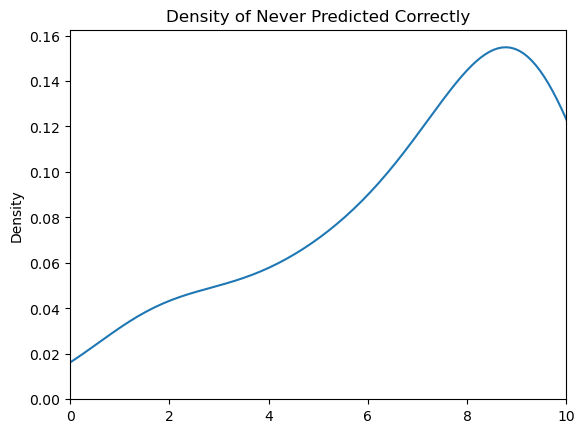

'\nA little strange that it diminishes at the far right edge but that could be sample variation.\nBut it is promising that it increasing in frequency with rank\n'

In [75]:
rank_10 = [i for i in grs_sec_means if i == 10]
print(len(rank_10))
fig, ax = plt.subplots()
#sns.distplot(data, ax = ax)
sns.kdeplot(np.array(grs_sec_means), bw=0.5,ax=ax).set(title="Density of Never Predicted Correctly")
# change the limits of X-axis
ax.set_xlim(0, 10)
plt.show()

"""
A little strange that it diminishes at the far right edge but that could be sample variation.
But it is promising that it increasing in frequency with rank
"""

# Looking at Rank 10 Never Correct Examples

In [76]:
filtered = list(filter(lambda x: x > 9, grs_sec_means))
print(filtered)


[9.9375, 10.0, 9.625, 9.9375, 9.5, 10.0, 10.0, 9.625, 9.6875, 9.5625, 9.9375, 9.1875, 10.0, 10.0, 9.8125, 10.0, 9.25, 9.5, 9.0625, 9.1875, 9.875, 10.0, 9.8125, 9.5, 9.375, 9.25, 9.1875, 10.0, 10.0, 10.0, 9.625, 10.0, 10.0, 9.6875, 9.5625, 9.8125, 9.9375, 9.5625, 9.75, 10.0, 9.4375, 9.375, 10.0, 10.0, 10.0, 10.0, 9.875, 9.375, 10.0, 9.375, 9.8125, 9.0625, 10.0, 9.125, 9.3125, 9.3125, 9.6875, 9.875, 9.6875, 9.75, 9.8125, 9.0625, 9.5, 9.5625, 9.3125, 9.875, 9.625, 10.0, 9.4375, 9.4375, 9.5, 10.0, 10.0, 10.0, 9.5625, 9.4375, 9.9375, 10.0, 10.0, 10.0, 9.125, 10.0, 9.6875, 9.8125, 9.5, 9.8125, 10.0, 9.375, 9.4375, 9.125, 9.375, 9.9375, 10.0, 9.875, 9.1875, 9.5625, 9.9375, 9.75, 9.9375, 9.4375, 9.6875, 10.0, 9.5, 9.4375, 9.125, 10.0, 9.5625, 9.0625, 10.0, 9.375, 9.375, 10.0, 9.3125, 10.0, 9.5, 9.5, 10.0, 9.8125, 9.1875, 9.3125, 9.6875, 10.0, 10.0, 9.125, 9.5625, 10.0, 9.625, 9.4375, 9.6875, 10.0, 10.0, 9.8125, 10.0, 10.0, 10.0, 9.6875, 9.9375, 9.875, 10.0, 9.5, 9.5, 9.4375, 9.1875]


476
There are 9.24 percent of the points at the right edge


'\nSince the far right is an aggregate of the edge, is it low\nenough to be non random? It increases as you get closer to the edge which is a positive sign\n'

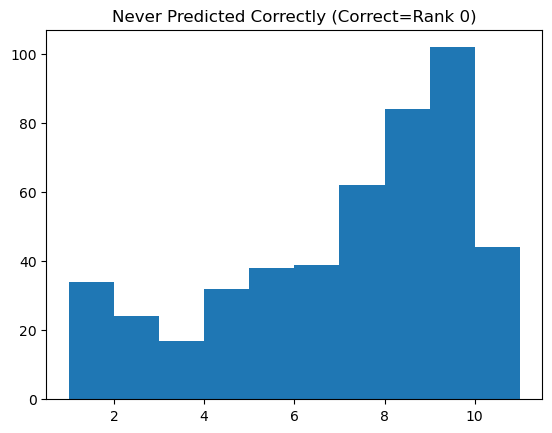

In [77]:
#gabriel Alon
#Never predicted correctly as below
print(len(grs_sec_means))
total_datapoints = len(grs_sec_means)
points_rank_10 = round((len(rank_10)/total_datapoints)*100,2)
print(f"There are {points_rank_10} percent of the points at the right edge")
plt.hist(grs_sec_means,bins=np.arange(min(grs_sec_means), max(grs_sec_means) + 2, 1))
plt.title("Never Predicted Correctly (Correct=Rank 0)")
"""
Since the far right is an aggregate of the edge, is it low
enough to be non random? It increases as you get closer to the edge which is a positive sign
"""

In [ ]:
plt.scatter(grs_pr_means,grs_pr_std,alpha = 0.4, marker = '.',color = 'grey')
plt.scatter(grs_sec_means,grs_sec_std,alpha = 0.4, marker = '.',color = 'blue')
plt.xlabel("Mean of Golden Rank")
plt.ylabel("Std Dev of Golden Rank")
plt.title("Golden Rank Mean vs. SD for all Examples\nGray examples have at least one Primary Prediction")
#plt.savefig('../assets/GR_mean_vs_std_Predicted_by_at_least_one_model.png',dpi=300)

The following statistics pertain to examples that have been predicted correctly at least once:

In [ ]:
m=grls_np.shape[1]
pr_na = np.sum([ a and b for (a,b) in zip(nas_np[0,:],np.min(grls_np,axis=0) == 0) ])
pr_ans = np.sum([ not a and b for (a,b) in zip(nas_np[0,:],np.min(grls_np,axis=0) == 0) ])
pr = np.sum(np.min(grls_np,axis=0) == 0)
print('Total number of examples:',m)
print ('There are %i examples that have been predicted correctly by at leat one experiment' % pr)
print('They are about evenly split between answerable (%i) and unanswearable (%i) examples'% (pr_ans,pr_na))
print ('The remaining %i examples (%.2f%%) are the only ones that appear exclusively in secondary predictions and none of the primary' %\
    (m-pr, (m-pr)/m*100))


The second graph shows the same mean-standard deviation plot for each example, in green for answerable examples and  red for those that have no answer.The answerable examples are more consistently predicted by the 16 models and remain closer to the higher ranking predictions (towards 0) while the no-answer examples are predicted less successfully and with wider variability.

In [ ]:
#GABRIEL ALON

dataframe = pd.DataFrame()
dataframe['na_means'] = grs_na_means
dataframe['na_std'] =grs_na_std
#dataframe.sort_values(by=['na_means','na_std'])
#dataframe.head()
dataframe_copy = dataframe[dataframe['na_means']>4]
dataframe_copy = dataframe_copy[dataframe_copy['na_means']<6]
dataframe_copy = dataframe_copy.sort_values(by=['na_std'])
#dataframe_middle = dataframe['na_means'].apply(lambda x: x if x>4)
print(dataframe_copy)
plt.scatter(dataframe_copy['na_means'],dataframe_copy['na_std'])
plt.title("Data points in the Middle")

"""
This plot shows that only a few questions have below sd 3 in the middle of the plot
and they are above an sd of 2
"""

In [ ]:
#add the seperate green and blue plots to the appendix

#GABRIEL ALON
#plt.scatter(grs_na_means,grs_na_std,alpha = 0.05, marker = '.',color = 'red')
#plt.scatter(grs_na_means,grs_na_std,alpha = 0.05, marker = '.',color = 'red')
plt.scatter(grs_ans_means,grs_ans_std,alpha = 0.5, marker = '.',color = 'green')
plt.scatter(grs_na_means,grs_na_std,alpha = 0.5, marker = '.',color = 'blue')
plt.xlabel("Mean of Golden Rank")
plt.ylabel("Std Dev of Golden Rank")
plt.title("Example Golden Rank Mean vs. SD\nGreen examples have answers, Red are Unanswerable")
#plt.savefig('../assets/GR_mean_vs_std_ans_vs_noAns.png',dpi=300)

In [ ]:
#gabrielalon
import scipy.stats as stats
stats.ttest_ind(a=grs_ans_means, b=grs_na_means, equal_var=True)
"""

Here, since the p-value (1.49 e-39) is less than alpha = 0.05 so we can reject 
the null hypothesis of the test. We have sufficient evidence to say that 
the two population means are different
"""

In [ ]:
"""
Suppose we wish to test the null hypothesis that two samples
were drawn from the same distribution. We choose a confidence 
level of 95%; that is, we will reject the null hypothesis in favor
of the alternative if the p-value is less than 0.05. We use the KS-Test.


"""
stats.ks_2samp(grs_ans_means, grs_na_means)
"""

The p-value of 1.3e-34 is  below our threshold of 0.05, so we can reject the null hypothesis for the
default “two-sided” alternative and conclude that the data were not drawn from the same distribution
"""


In [ ]:
import seaborn as sns
x = grs_ans_means
y = grs_ans_std
df = pd.DataFrame({'x': x, 'y': y})

sns.jointplot(data = df, x = 'x', y = 'y', kind = 'hist', xlim = (0, 1), ylim = (0, 1))

plt.show()

The following experiment counts correspond to the three points with zero standard deviation. These denote examples that have been consistently ranked for all 15 experiments.

In [ ]:
m = len(grs_means)
print('Examples ranked 0 for all experiments: %i or %.2f%%'%(np.sum([x==0 for x in grs_means]),np.sum([x==0 for x in grs_means])/m*100))
print('Examples ranked 10 or higher for all experiments: %i or %.2f%%'%(np.sum([x==10 for x in grs_means]),np.sum([x==10 for x in grs_means])/m*100))
v01 = np.sum([x==0 for x in grs_std])-np.sum([x==10 for x in grs_means])-np.sum([x==0 for x in grs_means])
print('Examples ranked 1 for all experiments: %i or %.2f%%' % (v01,v01/m*100))
print('Examples ranked 0 for all experiments with no answer: %i or %.2f%%'%(np.sum([x==0 for x in grs_na_means]),np.sum([x==0 for x in grs_na_means])/m*100))
print('Examples ranked 10 or higher for all experiments with no answer: %i or %.2f%%'%(np.sum([x==10 for x in grs_na_means]),np.sum([x==10 for x in grs_na_means])/m*100))
v11 = np.sum([x==0 for x in grs_na_std])-np.sum([x==10 for x in grs_na_means])-np.sum([x==0 for x in grs_na_means])
print('Examples ranked 1 for all experiments with no answer: %i or %.2f%%'%(v11,v11/m*100))
print('Examples ranked 0 for all answerable experiments: %i or %.2f%%'%(np.sum([x==0 for x in grs_ans_means]),np.sum([x==0 for x in grs_ans_means])/m*100))
print('Examples ranked 10 or higher for all answerable experiments: %i or %.2f%%'%(np.sum([x==10 for x in grs_ans_means]),np.sum([x==10 for x in grs_ans_means])/m*100))
v21=np.sum([x==0 for x in grs_ans_std])-np.sum([x==10 for x in grs_ans_means])-np.sum([x==0 for x in grs_ans_means])
print('Examples ranked 1 for all answerable experiments: %i or %.2f%%'%(v21,v21/m*100))



#grs.shape

In [ ]:
from IPython.display import display, HTML

def wrap_df_text(df):
    return display(HTML(df.to_html().replace("\\n","<br>")))


## Error Analysis - Clusters of Interest

### Four rank-1, sdv-0 examples
The next cell produces the four examples that rank 1 for all experiments. The result shows that three of them involve an incorrect "No Answer" prediction and one looks like an aberration in the golden answers where the returned rank-0 answer should be a correct answer. 

In [ ]:
df = RS.topNPredsDF()#topK=5)#, experimentIdx =experimentID)
df['experiment'] = [abbrevLabel[exp] for exp in df['experiment']]
df['id_short'] = [i[20:] for i in df['id']]

In [ ]:
pd.set_option('display.max_colwidth', 0)
[(x,y) for x,y in zip(grs_std,grs_means) if x ==0 and y == 1]#)-np.sum([x==10 for x in grs_means])-np.sum([x==0 for x in grs_means])
ixs = np.where(np.prod(grs,axis=0)==1)[0].tolist()
print(ixs)
ids = [x['id'] for i,x in enumerate(raw_datasets['validation']) if i in np.where(np.prod(grs,axis=0)==1)[0].tolist()]
print(ids)
df1 = df.loc[df.id.isin(ids)][['text','probability','id_short','rank','goldAns','correct']]
with open('../assets/errors_GR1_example_predictions_4.tex','w') as F:
    F.write(df1.query('rank < 2').to_latex(index=False))
display( df1.query('rank < 2'))



### Sample of highly polarized examples

In [ ]:
pd.set_option('display.max_colwidth', 0)
ixs=[(i,mu,std) for i,(mu,std) in enumerate(zip(grs_means,grs_std)) if std> 4.8  ]#)-np.sum([x==10 for x in grs_means])-np.sum([x==0 for x in grs_means])
ixs = [exs[0] for exs in random.sample(ixs,5)]
ids = [x['id'] for i,x in enumerate(raw_datasets['validation']) if i in ixs]
print(ids)
for id in ids:
    print('Example ID:',id)
    print(RS.dataset[RS.ix_id[id]])
    df1 = df.query('id == @id and (rank < 2 or correct == True)')
    #df1 = df.loc[(df.id==id & (df.rank == 0 or df.correct == True))]
    #df1['experiment'] = [abbrevLabel[exp] for exp in df1['experiment']]
    for experimentID in range(16):
        #[RS.topNPreds()[1][id][0] for id in ids]
        #df1['id'] = [i[20:] for i in df1['id']]
        df2 = df1[['text','probability','experiment','rank','goldAns','correct']]
        #wrap_df_text(df1)
    with open('../assets/errors_GR_polar_by_experiment_id_%s.tex'%id,'w') as F:
        F.write(df2.to_latex(index=False))
    display( df2)#.query('rank < 5'))

### Polarized Answerable Examples

In [178]:
pd.set_option('display.max_colwidth', 0)
ixs=[(i,mu,std) for i,(mu,std) in enumerate(zip(grs_means,grs_std)) if std> 4.5  ]#)-np.sum([x==10 for x in grs_means])-np.sum([x==0 for x in grs_means])
ixs = [x[0] for x in random.sample(ixs,40)]
ids = [x['id'] for i,x in enumerate(raw_datasets['validation']) if i in ixs and x['answers']['text'] != []]
print(ids)
for id in ids:
    print('Example ID:',id)
    df1 = df.query('id == @id and (rank < 2 or correct == True)')
    #df1 = df.loc[(df.id==id & (df.rank == 0 or df.correct == True))]
    for experimentID in range(16):
        #[RS.topNPreds()[1][id][0] for id in ids]
        #df1['id'] = [i[20:] for i in df1['id']]
        df2 = df1[['text','probability','experiment','rank','goldAns','correct']]
        #wrap_df_text(df1)
    with open('../assets/errors_GR_polar_answerable_%s.tex'%id,'w') as F:
        F.write(df2.query('rank < 5').to_latex(index=False))
    display( df2)#.query('rank < 5'))

['5705fec152bb89140068977b', '5725ce4d38643c19005acd51', '572820512ca10214002d9e72', '5730069004bcaa1900d77030']
Example ID: 5705fec152bb89140068977b


UndefinedVariableError: name 'id' is not defined

### All Experiments in Rank 10+

In [179]:
pd.set_option('display.max_colwidth', 0)
ixs=[(i,mu,std) for i,(mu,std) in enumerate(zip(grs_means,grs_std)) if mu == 10  ]
ixs = [x[0] for x in random.sample(ixs,10)]
ids = [x['id'] for i,x in enumerate(raw_datasets['validation']) if i in ixs and x['answers']['text'] != []]
print(ids)
for id in ids:
    print('Example ID:',id)
    df1 = df.query('id == @id and (rank < 3 or correct == True)')
    #df1 = df.loc[(df.id==id & (df.rank == 0 or df.correct == True))]
    for experimentID in range(16):
        #[RS.topNPreds()[1][id][0] for id in ids]
        #df1['id'] = [i[20:] for i in df1['id']]
        df2 = df1[['text','probability','experiment','rank','goldAns','correct']]
        #wrap_df_text(df1)
    with open('../assets/errors_GR_10_Plus_%s.tex'%id,'w') as F:
        F.write(df2.query('rank < 5').to_latex(index=False))
    display( df2)#.query('rank < 5'))

['571c91c8dd7acb1400e4c10b', '5727f05b4b864d190016406a', '572ffabf04bcaa1900d76f9f', '57308f6b8ab72b1400f9c584']
Example ID: 571c91c8dd7acb1400e4c10b


UndefinedVariableError: name 'id' is not defined

# K-Rank majority Ensemble

Instead of considering the majority of top choices, consider the majority of the top K ranks

## Selecting the Experiments

We select the experiments with the lowest GRIM

In [164]:
L = [i for i in range(len(RS.labels)) if '/na/' not in RS.labels[i]]
print(L)


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]


In [165]:
eSel = np.argsort([-1*metrics['EM'][i] for i in L ])[:5]
eSel = [L[i] for i in eSel] 
print(eSel)
[RS.labels[i] for i in eSel]

[5, 4, 12, 7, 11]


['bert-lg-uc-wwm-sq2/001',
 'bert-lg-cas-wwm/003',
 'roberta-sq2/002',
 'longformer-sq2/011',
 'roberta-sq2/001']

In [166]:
eSel = np.argsort([medians[i] for i in L ])[:5]
eSel = [L[i] for i in eSel] 
print(eSel)
[RS.labels[i] for i in eSel]

IndexError: index 1 is out of bounds for axis 0 with size 1

We then extract the topK answers from each of these models

In [167]:
K = 1
ansDict = {}
for expId in eSel:
    E = RS.topNPreds(experimentIdx=expId)[0]
    #print(len(E))
    for k,v in E.items():
        #print(k)
        if k not in ansDict:
            ansDict[k] = []
        for x in v :
            #print(x)
            if x['rank'] < K:
                ansDict[k].append(x['text'])
            else:
                break

predDict = {}
for k,l in ansDict.items():
    predDict[k] = max(l,key=l.count)
print(len(predDict))
print(len(ansDict))

11873
11873


In [168]:
res_EM = []
res_F1 = []
for k,p in predDict.items():
    answers = RS.dataset[RS.ix_id[k]]['answers']['text']
    if answers:
        res_EM.append(any([compute_em(a,p) for a in answers]))
        res_F1.append(any([compute_f1(a,p) for a in answers]))
    else:
        res_EM.append(normalize_answer(p) == '')
        res_F1.append(normalize_answer(p) == '')
print('EM =',sum(res_EM)/len(res_EM)*100)
print('F1 = ',sum(res_F1)/len(res_F1)*100)

EM = 83.3403520592942
F1 =  87.20626631853786


The best results are with K=1 and using the ensemble of the 5 lowest GRIM experiments.

In [169]:
predDict['56ddde6b9a695914005b9628']

'France'

## Other Clustering attempts

FileNotFoundError: [Errno 2] No such file or directory: '../assets/cluster5_all.png'

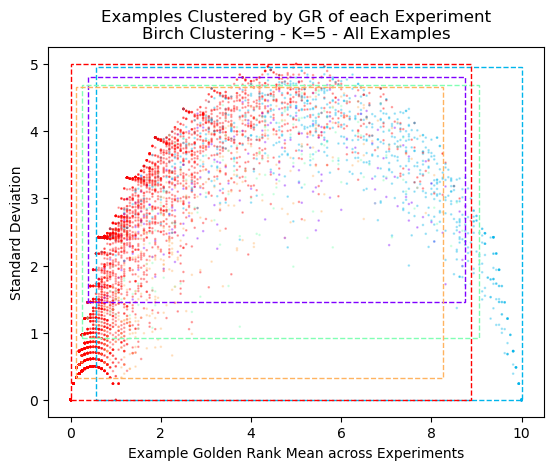

In [170]:
X = grls_np.T
X_means = grs_means
X_std = grs_std
maxBins = maxBins
K_clusters = 5

counts_pd = cluster_examples_by_GR(X = X, X_means= X_means, X_std = X_std, maxBins = maxBins, 
    K_clusters = K_clusters, slice_descr="All Examples", 
    save_path = Path("../assets/").joinpath("cluster5_all") )
with open('../assets/cluster5_all.tex','w') as F:
    F.write(counts_pd.to_latex(index=False))

print(counts_pd.to_string(index=False))


In [ ]:
X = grls_np.T
X_means = grs_means
X_std = grs_std
maxBins = maxBins
K_clusters = 4

counts_pd = cluster_examples_by_GR(X = X, X_means= X_means, X_std = X_std, maxBins = maxBins, 
    K_clusters = K_clusters, slice_descr="All Examples", 
    save_path = Path("../assets/").joinpath("cluster4_all") )
with open('../assets/cluster4_all.tex','w') as F:
    F.write(counts_pd.to_latex(index=False))
print(counts_pd.to_string(index=False))


In [ ]:
X = grs_na.T
X_means = grs_na_means
X_std = grs_na_std
maxBins = maxBins
K_clusters = 3

counts_pd = cluster_examples_by_GR(X = X, X_means= X_means, X_std = X_std, maxBins = maxBins, 
    K_clusters = K_clusters, slice_descr="Non-Answerable Only", 
    save_path = Path("../assets/").joinpath("cluster3_na") )
with open('../assets/cluster3_na.tex','w') as F:
    F.write(counts_pd.to_latex(index=False))
print(counts_pd.to_string(index=False))


FileNotFoundError: [Errno 2] No such file or directory: '../assets/cluster4_ans.png'

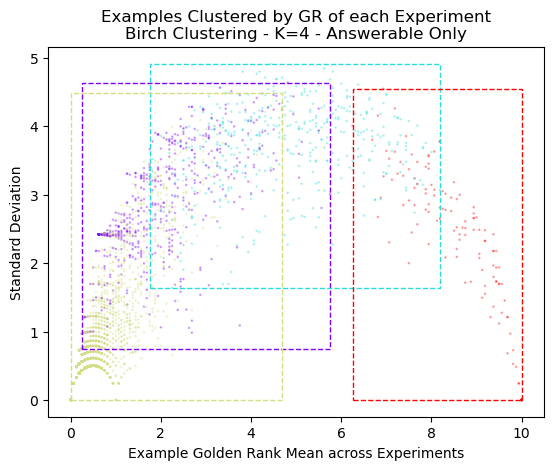

In [171]:
X = grs_ans.T
X_means = grs_ans_means
X_std = grs_ans_std
maxBins = maxBins
K_clusters = 4

counts_pd = cluster_examples_by_GR(X = X, X_means= X_means, X_std = X_std, maxBins = maxBins, 
    K_clusters = K_clusters, slice_descr="Answerable Only", 
    save_path = Path("../assets/").joinpath("cluster4_ans") )
with open('../assets/cluster4_ans.tex','w') as F:
    F.write(counts_pd.to_latex(index=False))
print(counts_pd.to_string(index=False))


In [ ]:
X = grs_ans.T
X_means = grs_ans_means
X_std = grs_ans_std
maxBins = maxBins
K_clusters = 3

counts_pd = cluster_examples_by_GR(X = X, X_means= X_means, X_std = X_std, maxBins = maxBins, 
    K_clusters = K_clusters, slice_descr="Answerable Only", 
    save_path = Path("../assets/").joinpath("cluster3_ans") )
with open('../assets/cluster3_ans.tex','w') as F:
    F.write(counts_pd.to_latex(index=False))
print(counts_pd.to_string(index=False))



## Golden Rank (GR)

The Golden Rank $R$ is the lowest rank in the order of descenting probability of the prediction exactly matching one of the golden answers. 

The output layer of the model yields a vector of start logits and end logits for each example.  These are then passed through masked softmax producing two probability vectors, one for the start marker and another for the end marker. 

The two probability vectors for each example are then combined to form a single probability which is the value provided in the top-N results. The choice of the function that combines the two probabilities to produce the combined probability in the Huggingface implementation is a simple average of the start and end probability. There are other possibilities however:

*   The product of the two probabilities can be used instead of the average (used in the BiDAF starter code) 
*   Taking a weighted average is discussed in various articles, for example in [*Question and Answering on SQuAD 2.0: BERT Is All You Need* by Schwager and Solitario](https://web.stanford.edu/class/archive/cs/cs224n/cs224n.1194/reports/default/15812785.pdf). They argue that the start probability carries more weight than the end probability so weighing the start twice as much as the end may be appropriate.
*  Hyperparameter settings favoring no-answer detection have weaker scores in F1 and exact match detection, and vice versa. This observation was made by the same paper above, and we confirmed it through our own experimentation. 

We now calculate the Golden Rank from the predictions in RS. 

The value maxBins is used to size the histograms to the ranks available in the data.
The topNPreds returns a list of dictionaries, one for each experiment. 
Each of these, are indexed by example ID, and they contain the list of ranked predictions for it. 
We walk down that list and rank the id with the rank of the first correct answer we encounter. If the list goes past the maxBins, the last bin contains the rank that captures the result. If no entry exists with a correct answer, then the default rank will be used.

In [172]:
grls_np, nas_np, maxBinsActual, mediansNonZeroRanks_np, grls = RS.calc_golden_ranks(maxBins = 10)
len(grls[10])

11873

## Mean rank

Smaller is better

In [173]:
np.mean(grls_np,axis=1)



array([1.62840057, 1.451276  , 1.2985766 , 1.24854712, 0.88200118,
       0.81310537, 1.06426345, 0.97186895, 1.13442264, 1.0146551 ,
       1.1908532 , 0.97287964, 0.8026615 , 1.63134844, 1.76130717,
       1.7447149 ])

## Median Rank

In [174]:
[np.median([r  for r in L if r>0]) for L in grls]

[5.0,
 4.0,
 3.0,
 3.0,
 3.0,
 2.0,
 4.0,
 3.0,
 4.0,
 3.0,
 4.0,
 3.0,
 2.0,
 3.0,
 4.0,
 4.0]

## Interpolated Median Rank

In [175]:
[median_grouped([r  for r in L if r>0]) for L in grls]


[5.3396946564885495,
 4.383620689655173,
 2.909090909090909,
 2.7009345794392523,
 2.7260273972602738,
 2.3793650793650793,
 3.65,
 3.125766871165644,
 3.84375,
 3.3986013986013988,
 4.378787878787879,
 3.1099290780141846,
 2.2329376854599405,
 3.4051383399209487,
 3.966824644549763,
 3.994949494949495]

## Scaterplots of Interpolated Median and Mean

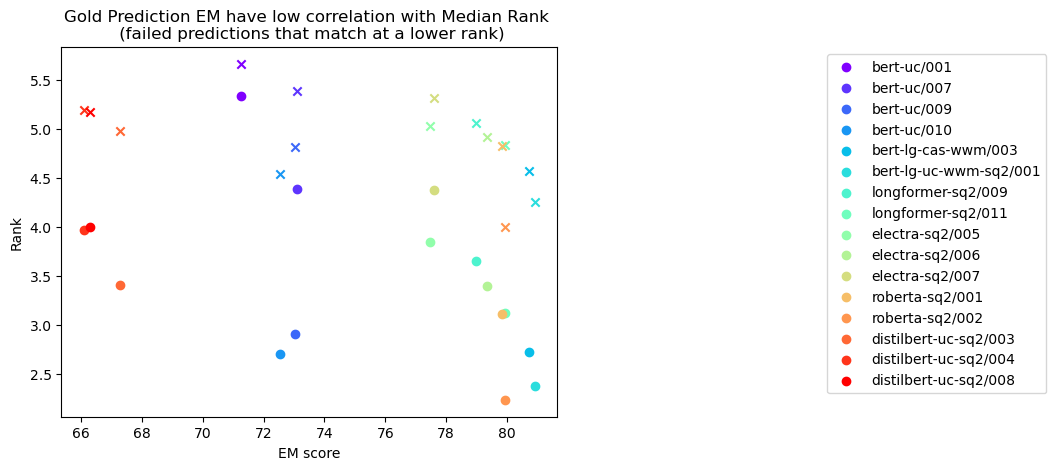

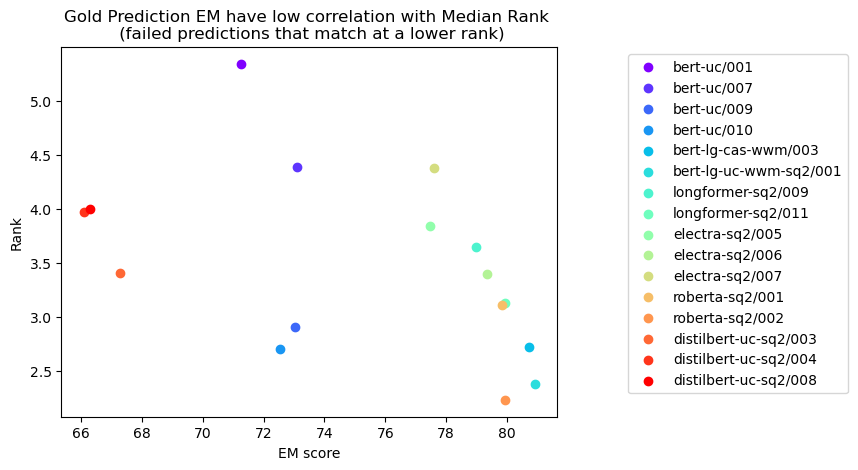

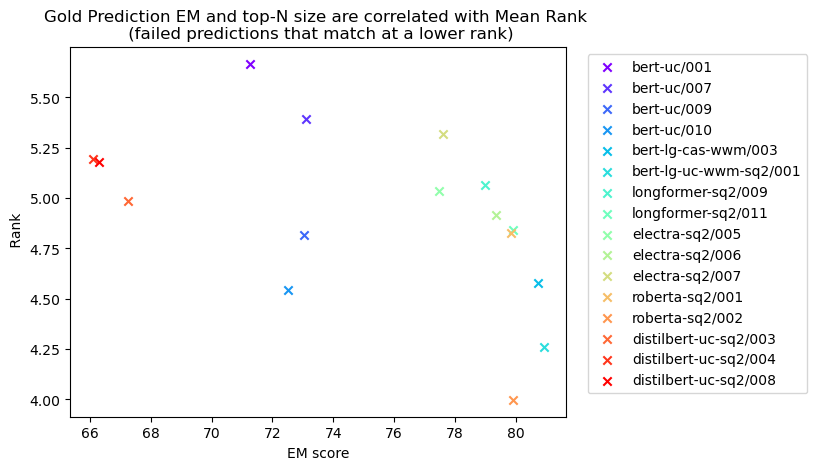

,EM,Median,Mean,labels
0,28.737472,5.339695,5.666471,bert-uc/001
1,26.909795,4.383621,5.393114,bert-uc/007
2,26.968753,2.909091,4.815116,bert-uc/009
3,27.474101,2.700935,4.544451,bert-uc/010
4,19.270614,2.726027,4.576923,bert-lg-cas-wwm/003
5,19.085320,2.379365,4.260371,bert-lg-uc-wwm-sq2/001
6,21.014066,3.650000,5.064529,longformer-sq2/009
7,20.079171,3.125767,4.840185,longformer-sq2/011
8,22.521688,3.843750,5.037023,electra-sq2/005
9,20.643477,3.398601,4.915137,electra-sq2/006


In [176]:
grls = grls #RS.topNPreds(topK=10)
R = []
md = []
mn = []
df = []
score = []
for L in grls:
    M = len(L)
    R = [r for r in L if r > 0]
    #md.append(median_grouped(R))
    #mn.append(np.mean(R))
    #score.append(np.array(R).shape[0]/M*100)
    df.append([np.array(R).shape[0]/M*100,median_grouped(R),np.mean(R)])
#md = np.array(md)
#mn = np.array(mn)
#score = np.array(score)
df = pd.DataFrame(df)
df.columns = ['EM','Median','Mean']
df['labels'] = RS.labels


#plt.scatter(score,md)
#plt.legend(labels=RS.experiments,loc='upper right', bbox_to_anchor=(2, 1))
#plt.title("Gold Pred Rank vs median\n of failed predictions")
#plt.show()

#plt.scatter(score,mn)
#plt.legend(labels=RS.experiments,loc='upper right', bbox_to_anchor=(2, 1))
#plt.title("Gold Pred Rank vs mean\n of failed predictions")
#plt.show()

colors = cm.rainbow(np.linspace(0, 1, len(df)))

#plt.scatter(df.EM,df.Mean,color=colors)
#plt.title("Gold Pred Rank vs median and mean\n of failed predictions")
#plt.legend(labels=df.experiment,loc='upper right', bbox_to_anchor=(2, 1))
#plt.show()

for x, y1,y2, c  in zip(100-df.EM,df.Median, df.Mean ,colors):
    plt.scatter(x, y1, marker='o', color=c)
plt.title("Gold Prediction EM have low correlation with Median Rank \n (failed predictions that match at a lower rank)")
plt.legend(labels=df.labels,loc='upper right', bbox_to_anchor=(2, 1))
plt.xlabel("EM score")
plt.ylabel("Rank")
for x, y1,y2, c  in zip(100-df.EM,df.Median, df.Mean ,colors):
    plt.scatter(x, y2, marker='x', color=c)

plt.show()

for x, y1,y2, c  in zip(100-df.EM,df.Median, df.Mean ,colors):
    plt.scatter(x, y1, marker='o', color=c)
plt.title("Gold Prediction EM have low correlation with Median Rank \n (failed predictions that match at a lower rank)")
plt.legend(labels=df.labels,loc='upper right', bbox_to_anchor=(1.6, 1))
plt.xlabel("EM score")
plt.ylabel("Rank")
plt.show()

for x, y1,y2, c  in zip(100-df.EM,df.Median, df.Mean ,colors):
    plt.scatter(x, y2, marker='x', color=c)
plt.title("Gold Prediction EM and top-N size are correlated with Mean Rank \n (failed predictions that match at a lower rank)")
plt.legend(labels=df.labels,loc='upper right', bbox_to_anchor=(1.5, 1))
plt.xlabel("EM score")
plt.ylabel(" Rank")
plt.show()

df